In [1]:

from math import sqrt
from numpy import split
from numpy import array
from pandas import read_csv
from sklearn.metrics import mean_squared_error
from matplotlib import pyplot
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.convolutional import Conv1D
from keras.layers.convolutional import MaxPooling1D

import numpy as np
import pandas as pd

import matplotlib.pyplot as plt

C:\Users\Javad\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


In [28]:
# Read the data
# 1- Simulated Time Series
#dataset = pd.read_csv('Simulated_Data.csv', index_col=[0])

# 2- Beijing PM2.5 Data Data Set 
# 2.1- Hourly data
dataset = pd.read_csv('Beijing_hourly.csv', index_col=['date'])

# 2.2- Daily resampled data
#dataset = pd.read_csv('Beijing_daily.csv')

dataset = dataset.values

In [29]:
dataset.shape

(41757, 8)

In [30]:
# A dataframe of K features
data = dataset
n_input = 20
n_out = 7

def split_dataset(data): # data is np.array of size T*n_features
    T = data.shape[0]
    split_ratio = 0.7
    t_split = np.int(np.floor(split_ratio * T))
    # split into train and test
    train, test = data[0: t_split], data[t_split:]
    return train, test



# convert data (train or test) into inputs (X) and outputs (y)
def to_supervised(data, n_input, n_out):
    idx_interest_var = 0 # gives the column index of the series in the data {0, 1, 2,..., n_feature-1}
    X = []
    y = []
    T_tr = data.shape[0]
    
    for i in range(T_tr - n_input - n_out + 1):
        X.append(data[i: i + n_input])
        y.append(data[i + n_input: i + n_input + n_out])
    X = np.array(X)
    y = np.array(y)
    
    # X and y have shapes of (#samples, n_input, n_feature) and (#samples, n_out, n_features) repectively.
    # y is always univariate (even if n_features>1), we should reshape it to (#samples, n_out)

    y = y[:,:, idx_interest_var]
    
    return X, y
    


# train the model
def build_model(train, n_input, n_out):
    # prepare data
    train_x, train_y = to_supervised(train, n_input, n_out)
    # define parameters
    verbose, epochs, batch_size = 1, 70, 16
    n_timesteps, n_features, n_outputs = train_x.shape[1], train_x.shape[2], train_y.shape[1]
    # define model
    model = Sequential()
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu', input_shape=(n_timesteps,n_features)))
    model.add(Conv1D(filters=32, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Conv1D(filters=16, kernel_size=3, activation='relu'))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Flatten())
    model.add(Dense(100, activation='relu'))
    model.add(Dense(n_outputs))
    model.compile(loss='mse', optimizer='adam')
    # fit network
    model.fit(train_x, train_y, epochs=epochs, batch_size=batch_size, verbose=verbose)
    return model, train_x, train_y

def evaluate(test, n_input, n_out, model):
    # prepare data
    test_x, test_y = to_supervised(test, n_input, n_out)
    y_hat = model.predict(test_x)
    n = y_hat.shape[0] 
    prediction_error = y_hat - test_y
    mse = np.sum(prediction_error**2, axis=0)/n   
    score = np.mean(mse)
    
    return mse, score, test_x, test_y, y_hat

In [34]:
train, test = split_dataset(data) 
m, train_x, train_y = build_model(train, n_input, n_out)
mse, score, test_x, test_y, y_hat = evaluate(test, n_input, n_out, m)

Epoch 1/70
29203/29203 [==============================] - 21s 730us/step - loss: 3593.9286
Epoch 2/70
29203/29203 [==============================] - 26s 882us/step - loss: 2774.9416
Epoch 3/70
29203/29203 [==============================] - 22s 736us/step - loss: 2643.8676
Epoch 4/70
29203/29203 [==============================] - 19s 646us/step - loss: 2581.5017
Epoch 5/70
29203/29203 [==============================] - 22s 764us/step - loss: 2537.2300
Epoch 6/70
29203/29203 [==============================] - 23s 777us/step - loss: 2506.1313
Epoch 7/70
29203/29203 [==============================] - 20s 686us/step - loss: 2480.2175
Epoch 8/70
29203/29203 [==============================] - 19s 636us/step - loss: 2466.6513
Epoch 9/70
29203/29203 [==============================] - 21s 706us/step - loss: 2443.0186
Epoch 10/70
29203/29203 [==============================] - 23s 785us/step - loss: 2432.6328
Epoch 11/70
29203/29203 [==============================] - 18s 604us/step - loss: 2425.87

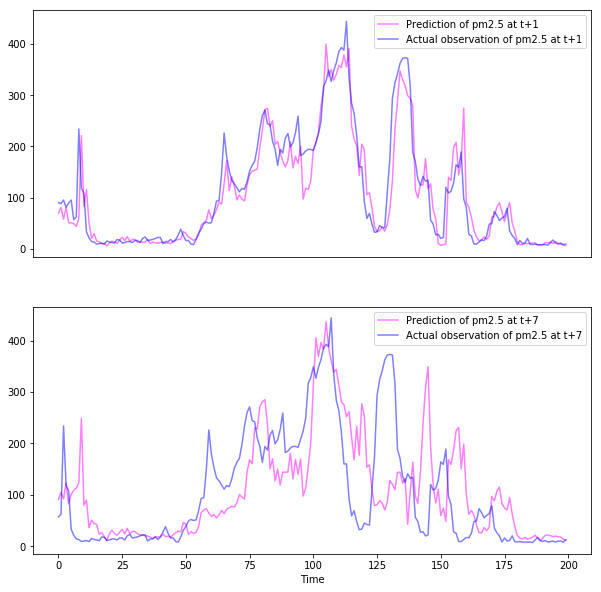

In [35]:

f, (a0, a1) = plt.subplots(2,1, gridspec_kw = {'height_ratios':[1, 1]}, figsize=(10, 10))
a0.plot(y_hat[-200:, 0], 'magenta', test_y[-200:, 0], 'b',alpha = 0.5)
a0.tick_params(
    axis='x',          # changes apply to the x-axis
    which='both',      # both major and minor ticks are affected
    bottom=False,      # ticks along the bottom edge are off
    top=False,         # ticks along the top edge are off
    labelbottom=False) # labels along the bottom edge are off
a0.legend(['Prediction of pm2.5 at t+1', 'Actual observation of pm2.5 at t+1' ])



a1.plot(y_hat[-200:, 6], 'magenta', test_y[-200:, 6], 'b',alpha = 0.5)
a1.legend(['Prediction of pm2.5 at t+7', 'Actual observation of pm2.5 at t+7' ])
a1.set_xlabel('Time');
plt.savefig(r'C:\Users\Javad\Dropbox\McGill ECON MA and PhD\2018\9- Fall 2018\1- ECON 706- Machine Learning\Project\Pics\Multistep_Multivar_predict_CNN_pm25')



In [32]:
mse, score

(array([ 588.84638908, 1120.63037423, 1671.39745523, 2216.28721554,
        2778.57964322, 3312.85643989, 3795.91556014]), 2212.073296759173)